# Generate GMM inclusion burden map for a sample slide

In [76]:
# Prelims
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import json
import copy
import torch.cuda as cutorch
import timeit
import scipy.special
import sys
import openslide
from scipy.ndimage import gaussian_filter

# Import modified wildcat
sys.path.append("wildcat.pytorch")
sys.path.append("../wildcat.pytorch")
sys.path.append("../")
import wildcat.models
from unet_wildcat_gmm import *

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.10.1+cu111
Torchvision Version:  0.10.1
CUDA status:  True
CUDA memory max alloc:        8 MB


## Experiment Setup

In [77]:
# Set the experiment directory
# exp_dir = "/home/me/data/patches/exp01"
exp_dir = "/data/pauly2/wildcat/data/thon2019/exp03_threads"

# Set the WSI file to process
wsi_file = "/data/pauly2/wildcat/data/HNL-32-18_HR2a_TAU_12.tif"

# Size of the training patch used to train wildcat, in raw pixels
patch_size_raw = 224

# Size of the window used to apply WildCat. Should be larger than the patch size
# This does not include the padding
window_size_raw = 224

## Load Configuration and Models

In [12]:
# Set main directories
data_dir = os.path.join(exp_dir, "patches")
model_dir = os.path.join(exp_dir, "models")

# Load model configuration from config.json
with open(os.path.join(model_dir, 'config.json'), 'r') as jfile:
    config = json.load(jfile)

# Set global properties
num_classes=config['num_classes']
input_size=config['wildcat_upsample']['input_size']
batch_size=config['wildcat_upsample']['batch_size']

In [13]:
# Create the model
model_ft = UNet_WSL_GMM(
    num_classes = config['num_classes'],
    mix_per_class=config['wildcat_upsample']['num_maps'], 
    kmax=config['wildcat_upsample']['kmax'], 
    kmin=config['wildcat_upsample']['kmin'],
    alpha=config['wildcat_upsample']['alpha'])

# Read model state
model_ft.load_state_dict(
    torch.load(os.path.join(model_dir, "wildcat_upsample.dat")))

# Send model to GPU
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Sending loaded model to device: ", device)
model_ft.eval()
model_ft = model_ft.to(device)

Sending loaded model to device:  cuda:1


## Load WSI

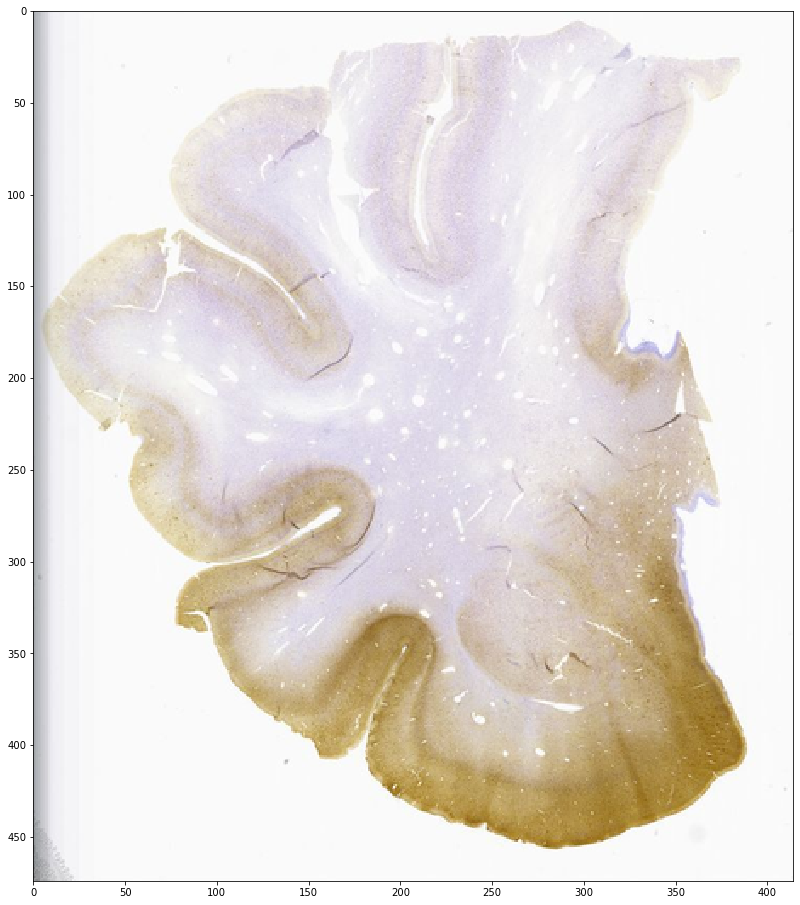

In [52]:
# Read a slide and show thumbnail
osl=openslide.OpenSlide(wsi_file)
plt.figure(figsize=(16,16))
plt.imshow(osl.get_thumbnail((512,512)), 
           extent=(0,osl.level_dimensions[0][0]/window_size_raw,osl.level_dimensions[0][1]/window_size_raw,0))
ax = plt.gca()
plt.xticks(np.arange(0,osl.level_dimensions[0][0]/window_size_raw,50));
plt.yticks(np.arange(0,osl.level_dimensions[0][1]/window_size_raw,50));

## Generate burden map
To speed this up, you can specify a sub-range of pixels to process

In [53]:
# u_range,v_range = None,None
u_range,v_range = (200,300),(300,400)


In [54]:
batch_size = 50

In [55]:
# The amount of padding, relative to patch size to add to the window. This padding
# is to provide context at the edges of the window
# padding_size_rel = 1.0
padding_size_rel = 0.0
padding_size_raw = int(padding_size_rel * patch_size_raw)

# Dimensions of the input image
slide_dim = np.array(osl.dimensions)

# Factor by which wildcat shrinks input images when mapping to segmentations
wildcat_shrinkage=1

# Additional shrinkage to apply to output (because we don't want to store very large)
# output images
extra_shrinkage=4

# Size of output pixel (in input pixels)
out_pix_size = wildcat_shrinkage * extra_shrinkage * patch_size_raw * 1.0 / input_size

# The output size for each window
window_size_out = int(window_size_raw / out_pix_size)

# The padding size for the output
padding_size_out = int(padding_size_rel * patch_size_raw / out_pix_size)

# Total number of non-overlapping windows to process
n_win = np.ceil(slide_dim / window_size_raw).astype(int)

# Output image size 
out_dim=(n_win * window_size_out).astype(int)

# Output array (last dimension is per-class probabilities)
density=np.zeros((2, out_dim[0], out_dim[1]))

# Range of pixels to scan
u_range = (0,n_win[0]) if u_range is None else u_range
v_range = (0,n_win[1]) if v_range is None else v_range

# Generate a list of patches that need to be processed
patch_list = []

# Range non-overlapping windows
for u in range(u_range[0], u_range[1]):
    for v in range(v_range[0], v_range[1]):
        patch_list.append((u,v))
        
# Transforms applied to read image chunks        
tran = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Size of the read image chunk
wp = window_size_raw+2*padding_size_raw
        
# Group the windows into minibatches
for i in range(0, len(patch_list), batch_size):
    
    # Size of the current minibatch
    batch = patch_list[i : i+batch_size]
    
    # Read the image chunks
    t0 = timeit.default_timer()
    I = torch.zeros((len(batch),3,wp,wp), device=device)
    for j, (u,v) in enumerate(batch):
        
        # Get the coordinates of the window in raw pixels
        x,y,w = u*window_size_raw,v*window_size_raw,window_size_raw
        
        # Subtract the padding
        xp,yp = x-padding_size_raw,y-padding_size_raw
        
        # Read the chunk from the image
        I[j,:,:,:] = tran(osl.read_region((xp,yp), 0, (wp,wp)).convert("RGB")).to(device)
        
    t1 = timeit.default_timer()
    
    # Process the batch using the network
    with torch.no_grad():

        # Forward pass through the wildcat model
        x_clas = model_ft.forward_to_classifier(I)
        x_cpool = torch.softmax((x_clas.permute(0, 2, 3, 1) @ model_ft.fc_pooled.weight.permute(1, 0) 
                                 + model_ft.fc_pooled.bias.view(1, 1, 1, -1)).permute(0, 3, 1, 2), 1)

        # Scale the cpool image to desired size
        x_cpool_up = torch.nn.functional.interpolate(x_cpool, scale_factor=1.0/extra_shrinkage).detach().cpu().numpy()

        # Extract the central portion of the output
        p0,p1 = padding_size_out,(padding_size_out+window_size_out)
        x_cpool_ctr = x_cpool_up[:,:,p0:p1,p0:p1]

    # Stick it into the output array
    for j, (u,v) in enumerate(batch):
        xout0,xout1 = u * window_size_out, ((u+1) * window_size_out)
        yout0,yout1 = v * window_size_out, ((v+1) * window_size_out)
        density[0,xout0:xout1,yout0:yout1] = x_cpool_ctr[j,0,:,:].transpose()
        density[1,xout0:xout1,yout0:yout1] = x_cpool_ctr[j,1,:,:].transpose()

    # Finished first pass through the chunk
    t2 = timeit.default_timer()
        
    # At this point we have a list of hits for this chunk
    print("Batch %4d/%4d: Times: IO=%6.4f WldC=%6.4f Totl=%8.4f" %
          (i // batch_size, len(patch_list) // batch_size, t1-t0,t2-t1,t2-t0))
        
# Trim the density array to match size of input
out_dim_trim=np.round((slide_dim/out_pix_size)).astype(int)
density=density[:,0:out_dim_trim[0],0:out_dim_trim[1]]

Batch    0/ 200: Times: IO=0.1518 WldC=0.2613 Totl=  0.4130
Batch    1/ 200: Times: IO=0.1477 WldC=0.2621 Totl=  0.4098
Batch    2/ 200: Times: IO=0.0953 WldC=0.2620 Totl=  0.3573
Batch    3/ 200: Times: IO=0.1096 WldC=0.2620 Totl=  0.3716
Batch    4/ 200: Times: IO=0.0985 WldC=0.2616 Totl=  0.3601
Batch    5/ 200: Times: IO=0.0982 WldC=0.2624 Totl=  0.3606
Batch    6/ 200: Times: IO=0.1061 WldC=0.2621 Totl=  0.3682
Batch    7/ 200: Times: IO=0.0937 WldC=0.2615 Totl=  0.3552
Batch    8/ 200: Times: IO=0.1037 WldC=0.2622 Totl=  0.3658
Batch    9/ 200: Times: IO=0.1064 WldC=0.2624 Totl=  0.3688
Batch   10/ 200: Times: IO=0.1121 WldC=0.2621 Totl=  0.3741
Batch   11/ 200: Times: IO=0.1052 WldC=0.2627 Totl=  0.3679
Batch   12/ 200: Times: IO=0.0957 WldC=0.2629 Totl=  0.3586
Batch   13/ 200: Times: IO=0.0925 WldC=0.2625 Totl=  0.3550
Batch   14/ 200: Times: IO=0.0795 WldC=0.2630 Totl=  0.3425
Batch   15/ 200: Times: IO=0.0678 WldC=0.2633 Totl=  0.3311
Batch   16/ 200: Times: IO=0.0803 WldC=0

Batch  137/ 200: Times: IO=0.1121 WldC=0.2658 Totl=  0.3780
Batch  138/ 200: Times: IO=0.1086 WldC=0.2662 Totl=  0.3747
Batch  139/ 200: Times: IO=0.0930 WldC=0.2661 Totl=  0.3591
Batch  140/ 200: Times: IO=0.1079 WldC=0.2657 Totl=  0.3737
Batch  141/ 200: Times: IO=0.0930 WldC=0.2654 Totl=  0.3584
Batch  142/ 200: Times: IO=0.0793 WldC=0.2664 Totl=  0.3457
Batch  143/ 200: Times: IO=0.0668 WldC=0.2672 Totl=  0.3340
Batch  144/ 200: Times: IO=0.0817 WldC=0.2658 Totl=  0.3475
Batch  145/ 200: Times: IO=0.1034 WldC=0.2659 Totl=  0.3692
Batch  146/ 200: Times: IO=0.1017 WldC=0.2663 Totl=  0.3681
Batch  147/ 200: Times: IO=0.0949 WldC=0.2664 Totl=  0.3613
Batch  148/ 200: Times: IO=0.0962 WldC=0.2660 Totl=  0.3622
Batch  149/ 200: Times: IO=0.1054 WldC=0.2656 Totl=  0.3710
Batch  150/ 200: Times: IO=0.0999 WldC=0.2662 Totl=  0.3661
Batch  151/ 200: Times: IO=0.0932 WldC=0.2666 Totl=  0.3598
Batch  152/ 200: Times: IO=0.0970 WldC=0.2664 Totl=  0.3634
Batch  153/ 200: Times: IO=0.0941 WldC=0

In [56]:
# Compute the default v_range
v_range_def = (0.5,1.0)

# A function to plot a region of the histology image and corresponding tangle prediction
def plot_classification_region(u0,v0,u1,v1,d_sample,vrange=v_range_def,sigma=0,show_ticks=True):
    # The image region
    img_rgn=osl.read_region((u0,v0), d_sample,
                            (int((u1-u0)/osl.level_downsamples[d_sample]),
                             int((v1-v0)/osl.level_downsamples[d_sample])))
    
    # The tangle map
    o_u0 = int(u0 / out_pix_size)
    o_v0 = int(v0 / out_pix_size)
    o_u1 = int(u1 / out_pix_size)
    o_v1 = int(v1 / out_pix_size)
    # t_map=density[1,o_u0:o_u1,o_v0:o_v1].transpose()-density[0,o_u0:o_u1,o_v0:o_v1].transpose()
    # t_map=np.where(t_map > 0, t_map, 0)
    t_map=density[1,o_u0:o_u1,o_v0:o_v1].transpose()
    
    # Smooth the tangle map
    t_map = gaussian_filter(t_map, sigma)
    
    # Create plots side by side
    fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(20,10))
    
    # Plot the image region
    ax[0].imshow(img_rgn, extent=(u0,u1,v1,v0))
    ax[0].grid(color='black', linestyle='-', linewidth=0.5)
    cs=ax[1].imshow(t_map, plt.get_cmap("jet"), vmin=vrange[0], vmax=vrange[1], extent=(u0,u1,v1,v0))
    ax[1].grid(color='black', linestyle='-', linewidth=0.5)
    # ax[1].colorbar(cs)
    if show_ticks is False:
        ax[0].xaxis.set_ticklabels([])
        ax[1].xaxis.set_ticklabels([])
        ax[0].yaxis.set_ticklabels([])
        ax[1].yaxis.set_ticklabels([])
    fig.show()

# Visualize burden map

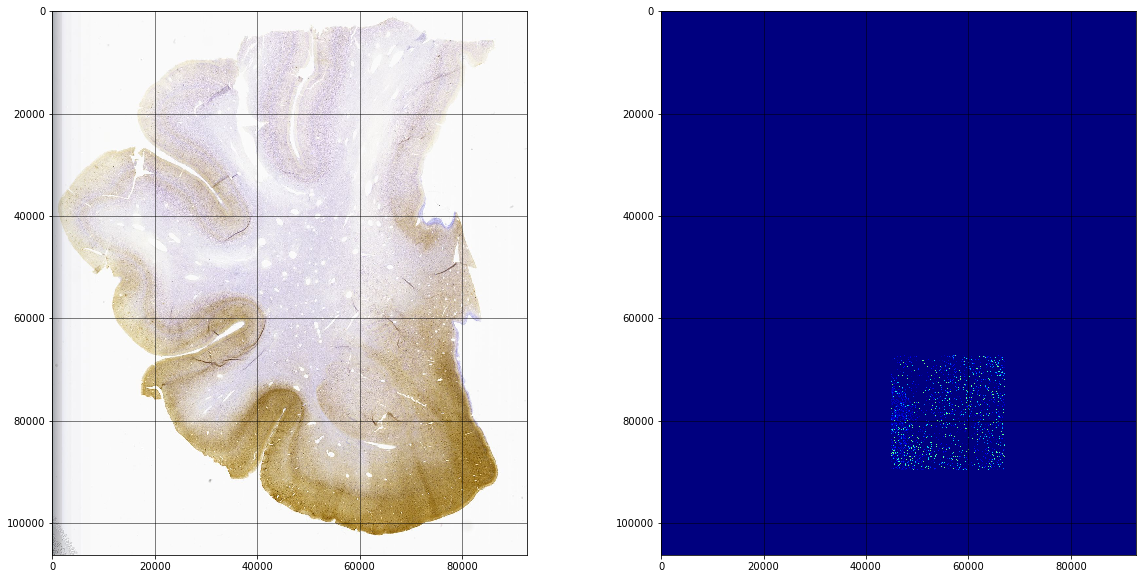

In [78]:
# plot_classification_region(7500,5000,42500,40000,2,(-3,3),10, show_ticks=True)
plot_classification_region(0,0,slide_dim[0],slide_dim[1],6)

In [79]:
uu,vv = np.array(u_range) * patch_size_raw,np.array(v_range) * patch_size_raw

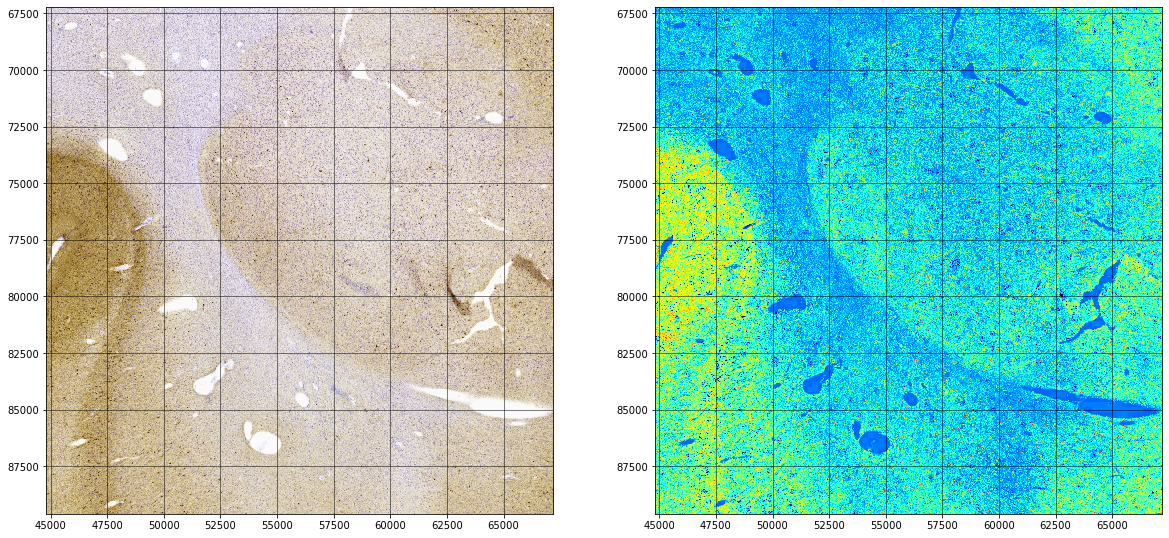

In [80]:
plot_classification_region(uu[0],vv[0],uu[1],vv[1],4,vrange=(0.2,0.7),sigma=2,show_ticks=True)

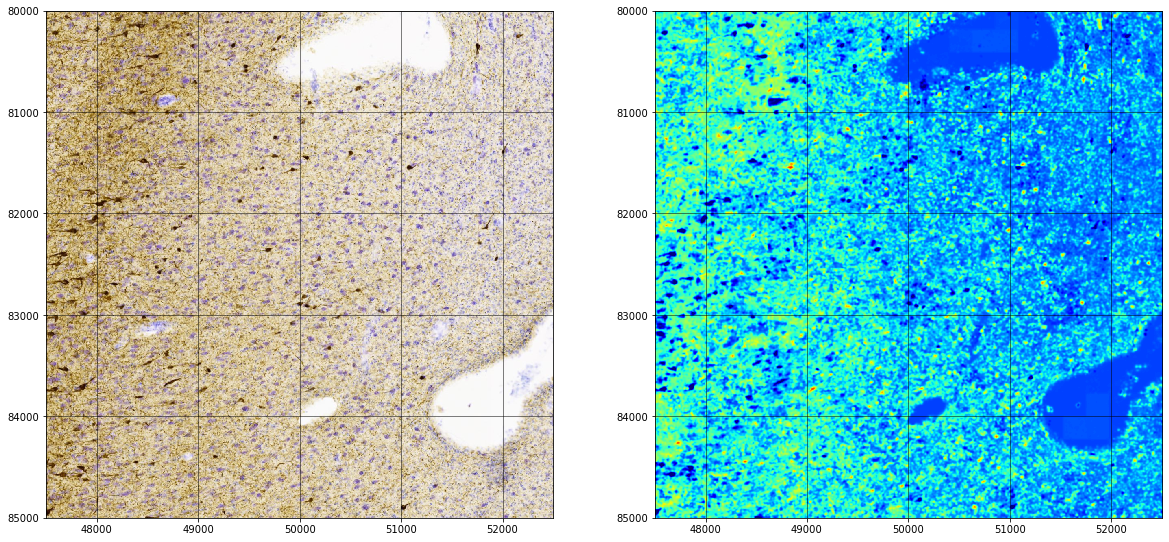

In [81]:
plot_classification_region(47500,80000,52500,85000,2,sigma=2,vrange=(0.2,0.8),show_ticks=True)

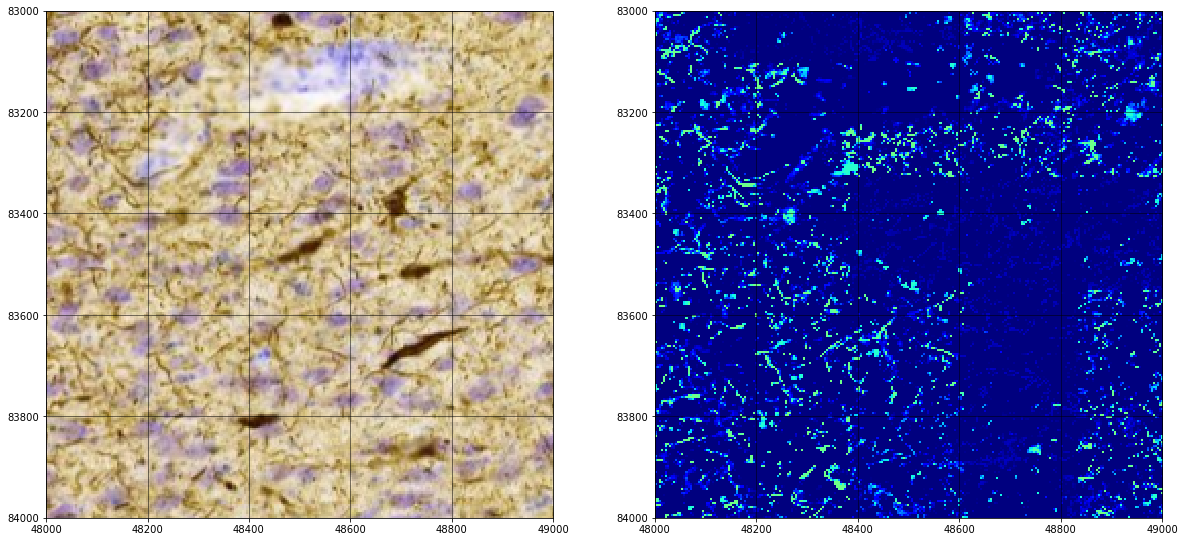

In [82]:
plot_classification_region(48000,83000,49000,84000,2,sigma=0,show_ticks=True)

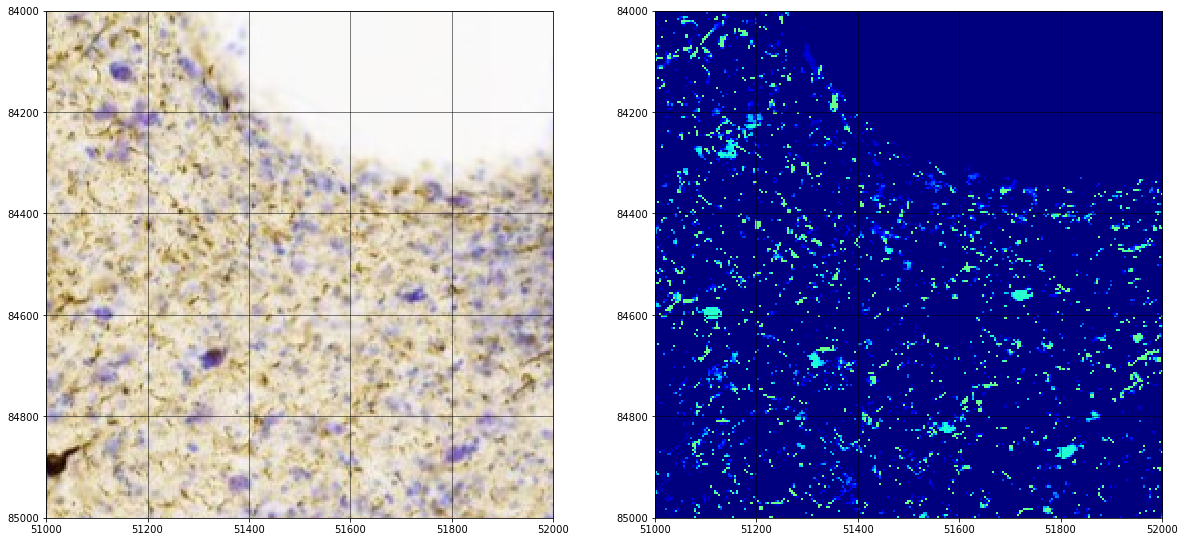

In [84]:
plot_classification_region(51000,84000,52000,85000,2,sigma=0,show_ticks=True)